In [7]:
!conda install -y gdown
!gdown https://drive.google.com/uc?id=1X407kBkhTAnaeBC19KpP1ocOXs6Q5O4T

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.13.0               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          22 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.0.12-pyh9f0ad1d_0
  gdown              conda-forge/noarch::gdown-3.13.0-pyhd8ed1ab_0



gdown-3.13.0         | 12 KB     | ##################################### | 100% 
filelock-3.0.12      | 10 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Downloading...

In [8]:
!unzip "./BRSeperated.zip"

Archive:  ./BRSeperated.zip
   creating: content/Output/
   creating: content/Output/val/
   creating: content/Output/val/COVID/
  inflating: content/Output/val/COVID/BRCOVID-2945.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-3496.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-2039.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-560.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-2263.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-1398.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-371.png.jpg  
  inflating: content/Output/val/COVID/BRcovid-19-pneumonia-progression-and-regression-day11.jpg.jpg  
  inflating: content/Output/val/COVID/BRCOVID-2402.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-3589.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-1113.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-2226.png.jpg  
  inflating: content/Output/val/COVID/BRCOVID-3031.png.jpg  
  inflating: content/Output/val/COVID/B

In [9]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
img_height,img_width=(228,228)
batch_size=64
train_data_dir="./content/Output/train"
valid_data_dir="./content/Output/val"
test_data_dir="./content/Output/test"

In [11]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle='False')
valid_generator=train_datagen.flow_from_directory(valid_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle='False')
print(valid_generator.class_indices)
print(train_generator.class_indices)

Found 16673 images belonging to 4 classes.
Found 5556 images belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Pneumonia': 3}


In [ ]:
#new model for resnet
from tensorflow import keras
from tensorflow.keras import layers
base_model=ResNet50(include_top=False,
                    weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers:
  layer.trainable=False
opt = keras.optimizers.Adam(learning_rate=2e-4)
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [12]:
!nvidia-smi

Tue May 18 04:47:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
#Getting BR160
!gdown https://drive.google.com/uc?id=1eUpc0kCqyLbo8MbIuRObb2DKUno9L653

Downloading...
From: https://drive.google.com/uc?id=1eUpc0kCqyLbo8MbIuRObb2DKUno9L653
To: /kaggle/working/BRpure160.h5
120MB [00:01, 98.0MB/s] 


In [14]:
from tensorflow import keras
model = keras.models.load_model("./BRpure160.h5")

In [15]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint=ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/110
260/260 [==============================] - 284s 1s/step - loss: 0.1107 - accuracy: 0.9573 - val_loss: 0.4457 - val_accuracy: 0.8676

Epoch 00001: val_accuracy improved from -inf to 0.86755, saving model to weights-improvement-01-0.87.hdf5
Epoch 2/110
260/260 [==============================] - 277s 1s/step - loss: 0.1209 - accuracy: 0.9523 - val_loss: 0.4702 - val_accuracy: 0.8712

Epoch 00002: val_accuracy improved from 0.86755 to 0.87118, saving model to weights-improvement-02-0.87.hdf5
Epoch 3/110
260/260 [==============================] - 273s 1s/step - loss: 0.1033 - accuracy: 0.9598 - val_loss: 0.4750 - val_accuracy: 0.8726

Epoch 00003: val_accuracy improved from 0.87118 to 0.87264, saving model to weights-improvement-03-0.87.hdf5
Epoch 4/110
260/260 [==============================] - 277s 1s/step - loss: 0.1114 - accuracy: 0.9572 - val_loss: 0.5012 - val_accuracy: 0.8641

Epoch 00004: val_accuracy did not improve from 0.87264
Epoch 5/110
260/260 [====================

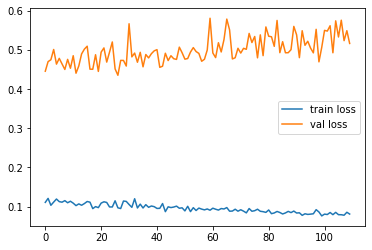

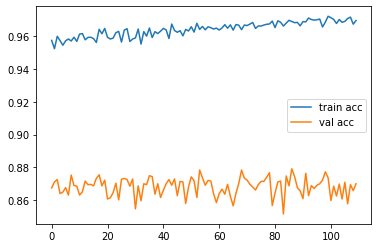

<Figure size 432x288 with 0 Axes>

In [16]:
r = model.fit_generator(
  train_generator,
  epochs=110,
  steps_per_epoch=16673//(batch_size),
  validation_data=valid_generator,
  validation_steps=5556//(batch_size),
  callbacks=callbacks_list
)
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [21]:
model.save("./BRPure270.h5")

In [18]:
test_generator=train_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle='False'
                                                  )
print(test_generator.class_indices)

Found 5561 images belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Pneumonia': 3}


In [20]:
test_loss,test_acc=model.evaluate(test_generator,verbose=1)
print("Test accuracy:",test_acc)
print("Test Loss:",test_loss)
test_generator.shuffle=False
test_generator.reset()
Y_pred = model.predict_generator(test_generator,verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Covid','Lung_Opacity','Normal','Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
cm=confusion_matrix(test_generator.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("class specific accuracy:")
print(cm.diagonal())
acsa = (cm[0,0]/sum(cm[0,:])+cm[1,1]/sum(cm[1,:])+cm[2,2]/sum(cm[2,:]))/3
print("average class specific accuracy :",acsa)
class_acc = [cm[i,i]/np.sum(cm[i,:]) if np.sum(cm[i,:]) else 0 for i in range(len(cm))]
print("class accuracy :",class_acc)
ppvs = [cm[i,i]/np.sum(cm[:,i]) if np.sum(cm[:,i]) else 0 for i in range(len(cm))]
print("predicted positive value :",ppvs)

87/87 [==============================] - 69s 793ms/step - loss: 0.4731 - accuracy: 0.8756
Test accuracy: 0.8755619525909424
Test Loss: 0.4731481671333313


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


87/87 [==============================] - 69s 797ms/step
Confusion Matrix
[[ 767   21   16   35]
 [  18  983   57  145]
 [  17   69 1941   12]
 [  39  227   27 1187]]
Classification Report
              precision    recall  f1-score   support

       Covid       0.91      0.91      0.91       839
Lung_Opacity       0.76      0.82      0.79      1203
      Normal       0.95      0.95      0.95      2039
   Pneumonia       0.86      0.80      0.83      1480

    accuracy                           0.88      5561
   macro avg       0.87      0.87      0.87      5561
weighted avg       0.88      0.88      0.88      5561

class specific accuracy:
[0.91418355 0.81712386 0.95193722 0.80202703]
average class specific accuracy : 0.8944148776670063
class accuracy : [0.9141835518474375, 0.8171238570241064, 0.9519372241294752, 0.802027027027027]
predicted positive value : [0.9484856127383389, 0.7938080087352778, 0.9182978300946795, 0.8266951155931874]
